# E17 다음에 볼 영화 예측하기

## 프로젝트 목표 : session based recommendation 구현하여 다음에 볼 영화 예측하기

## Step 1. 데이터의 전처리

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
import datetime, time
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [2]:
data_path = Path(os.getenv('HOME')+'/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


#### 유저수 : 6040,  시간값 : 3706

In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

#### 유저 아이디 마다 데이터 수

In [4]:
userid_length = data.groupby('UserId').size()
userid_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

#### 유저 아이디의 데이터 중 평균과 중앙값, 제일 많은 데이터, 제일 작은 데이터

In [5]:
userid_length.median(), userid_length.mean()

(96.0, 165.5975165562914)

In [6]:
userid_length.min(), userid_length.max()

(20, 2314)

In [7]:
userid_length.quantile(0.9)

400.0

#### 보통 유저가 시청한 영화편수는 평균 165편 정도입니다.
#### 제일 많이 보신 분이 2314편..   정말 많이 보시는군요.
#### 90% 범위에는 400편 이하입니다. 데이터가 문제 없는지 확인해 봅니다

In [8]:
length_count = userid_length.groupby(userid_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_90 = length_percent_cumsum[length_percent_cumsum < 0.90]

length_percent_cumsum_90

20     0.014238
21     0.029305
22     0.042053
23     0.055464
24     0.068874
         ...   
395    0.897682
396    0.897848
397    0.898344
398    0.899007
399    0.899834
Length: 376, dtype: float64

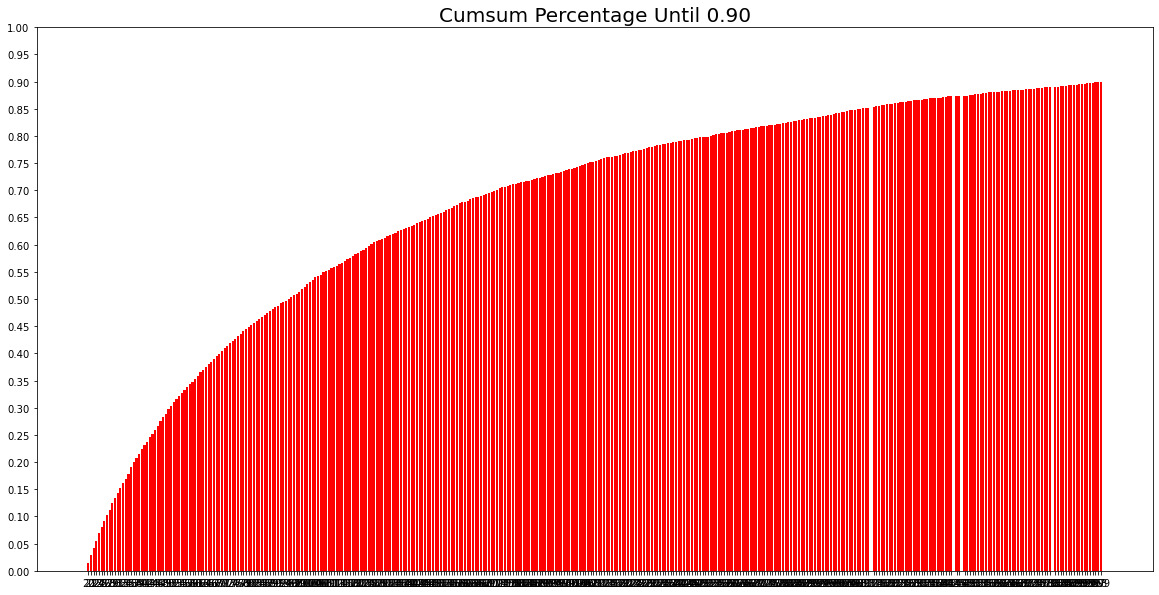

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_90.index,
        height=length_percent_cumsum_90, color='red')
plt.xticks(length_percent_cumsum_90.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.90', size=20)
plt.show()

In [10]:
times = data["Time"] 
temp_list = [] 
for time in times: 
    #temp_date = dt.datetime.fromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S')
    temp_date = dt.datetime.fromtimestamp(time)
    temp_list.append(temp_date)
#print(temp_list)
data["Time"] = temp_list 
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
27,1,1721,4,2001-01-01 07:00:55
37,1,1022,5,2001-01-01 07:00:55
24,1,2340,3,2001-01-01 07:01:43


### 데이터 정제하기

In [11]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [12]:
data = cleanse_recursive(data, shortest=100, least_click=100)
len(data)

775176

## Step 2. 미니 배치의 구성

In [13]:
## 데이터 분할하기
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [14]:
tr, test = split_by_date(data, n_days=90)
tr, val = split_by_date(tr, n_days=90)

In [15]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [16]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 652084
	 Sessions: 2531
	 Items: 1919
	 First Time : 2000-04-26 08:05:32
	 Last Time : 2002-09-01 05:38:06

* valid Set Stats Info
	 Events: 37915
	 Sessions: 98
	 Items: 1917
	 First Time : 2000-04-28 01:38:08
	 Last Time : 2002-11-30 22:47:32

* test Set Stats Info
	 Events: 85177
	 Sessions: 199
	 Items: 1919
	 First Time : 2000-05-01 20:15:13
	 Last Time : 2003-03-01 02:49:50



In [17]:
# train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [18]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [19]:
# dataset 만들기
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [20]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
130,2,1198,4,2001-01-01 06:28:44,0
64,2,1210,4,2001-01-01 06:29:11,1
71,2,1217,3,2001-01-01 06:29:11,2
134,2,2717,3,2001-01-01 06:29:56,3
88,2,1293,5,2001-01-01 06:31:01,4
170,2,2943,4,2001-01-01 06:32:52,5
106,2,1225,5,2001-01-01 06:33:11,6
120,2,1193,5,2001-01-01 06:33:33,7
172,2,318,5,2001-01-01 06:33:33,8
70,2,3030,4,2001-01-01 06:33:54,9


In [21]:
tr_dataset.click_offsets

array([     0,    125,    297, ..., 651653, 651771, 652084], dtype=int32)

In [22]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 2528, 2529, 2530])

In [23]:
# data loader 만들기
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [24]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(20)

,UserId,ItemId,Rating,Time,item_idx
130,2,1198,4,2001-01-01 06:28:44,0
64,2,1210,4,2001-01-01 06:29:11,1
71,2,1217,3,2001-01-01 06:29:11,2
134,2,2717,3,2001-01-01 06:29:56,3
88,2,1293,5,2001-01-01 06:31:01,4
170,2,2943,4,2001-01-01 06:32:52,5
106,2,1225,5,2001-01-01 06:33:11,6
120,2,1193,5,2001-01-01 06:33:33,7
172,2,318,5,2001-01-01 06:33:33,8
70,2,3030,4,2001-01-01 06:33:54,9


In [25]:
iter_ex = iter(tr_data_loader)

In [26]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0   3   1 354]
Label Item Idx are :       [  1 125 277 355]
Previous Masked Input Idx are []


## Step 3. 모델 구성

In [27]:
# 평가 지표
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [28]:
# 모델 구성
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [29]:
# 하이퍼 파라미터
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=30, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [30]:
# 모델 만들기
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 1919)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 30), (64, 30)]      175590    
_________________________________________________________________
dropout (Dropout)            (64, 30)                  0         
_________________________________________________________________
dense (Dense)                (64, 1919)                59489     
Total params: 235,079
Trainable params: 235,079
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습

In [31]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.
            #reset_hidden_states_2(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            
            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def reset_hidden_states_2(model, mask):
    gru_layer = model.get_layer(name='GRU1')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)
    
    gru_layer = model.get_layer(name='GRU2')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)
    
    

def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []
    total_step = len(data) - data['UserId'].nunique()
    
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        #reset_hidden_states_2(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr


In [32]:
train_model(model, args)

Train:   0%|          | 0/10149 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.74]

	 - Recall@20 epoch 1: 0.214454
	 - MRR@20    epoch 1: 0.051276



Train:   0%|          | 0/10149 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.44]

	 - Recall@20 epoch 2: 0.275255
	 - MRR@20    epoch 2: 0.072144



Train:   0%|          | 0/10149 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.28]

	 - Recall@20 epoch 3: 0.297253
	 - MRR@20    epoch 3: 0.081066



Train:   0%|          | 0/10149 [00:00<?, ?it/s, accuracy=0.141, train_loss=4.78] 

	 - Recall@20 epoch 4: 0.308629
	 - MRR@20    epoch 4: 0.086158



Evaluation:  56%|█████▌    | 331/590 [00:56<00:44,  5.82it/s]

	 - Recall@20 epoch 5: 0.314671
	 - MRR@20    epoch 5: 0.089285



## Step 5. 모델 테스트

In [33]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  80%|████████  | 1067/1327 [03:07<00:45,  5.68it/s]

	 - Recall@20: 0.273621
	 - MRR@20: 0.077346



## 루브릭 평가

1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.
	데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.
    ---> 완료
2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.
	적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.
    ---> 완료
3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.
	3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.
    ---> 미완료,  한개만...

## 느낀점 및 회고

추천시스템 중에 그나마 이해가 되면서 작성해 보았습니다. 오랜만에.... 